### 2a) Finding the best time of day and day of week to minimise delays

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker


In [6]:
# Reading the data & combining the years data into flights_df dataframe
years = range(2004, 2009)
file_names = [f"{year}.csv.bz2" for year in years]

# Load and concatenate flight data without filtering
chunks = []
for fname, year in zip(file_names, years):
    chunk = pd.read_csv(fname, low_memory = False).assign(Year = year)
    chunks.append(chunk)

flights_df = pd.concat(chunks, ignore_index = True)


In [7]:
# Filtering the data for analysis
flights_filtered = flights_df[
    (flights_df['Cancelled'] == 0) &
    (flights_df['Diverted'] == 0) &
    (flights_df['DepTime'] < 2400) &
    (flights_df['ArrTime'] < 2400)
]


In [8]:
# Droping unnecessary columns from the dataset
cols_to_drop = ['TaxiIn', 'TaxiOut', 'CancellationCode',
                'CarrierDelay', 'WeatherDelay', 'SecurityDelay', 'NasDelay', 'LateAircraftDelay']
flights_filtered = flights_df.drop(columns = cols_to_drop, errors = 'ignore')

In [5]:
# Convertung year to string for better readability
flights_filtered['Year'] = flights_filtered['Year'].astype(str)

In [ ]:
# Assign delay categories based on arrival delay values
flights_filtered['delay_category'] = pd.cut(
    flights_filtered['ArrDelay'],
    bins = [-np.inf, 0, 15, 30, 45, np.inf],
    labels = ["Early", "On-Time", "Short Delay", "Medium Delay", "Long Delay"],
    right = False
)

# Define the order of delay categories
flights_filtered['delay_category'] = pd.Categorical(
    flights_filtered['delay_category'],
    categories = ["Early", "On-Time", "Short Delay", "Medium Delay", "Long Delay"],
    ordered = True
)


In [8]:
# Calculate delay percentages per year and category
delay_perc = flights_filtered.groupby(['Year', 'delay_category'], observed = True).size().reset_index(name='count')
delay_perc['percentage'] = delay_perc.groupby('Year')['count'].transform(lambda x: x / x.sum() * 100)

<Figure size 1800x600 with 0 Axes>

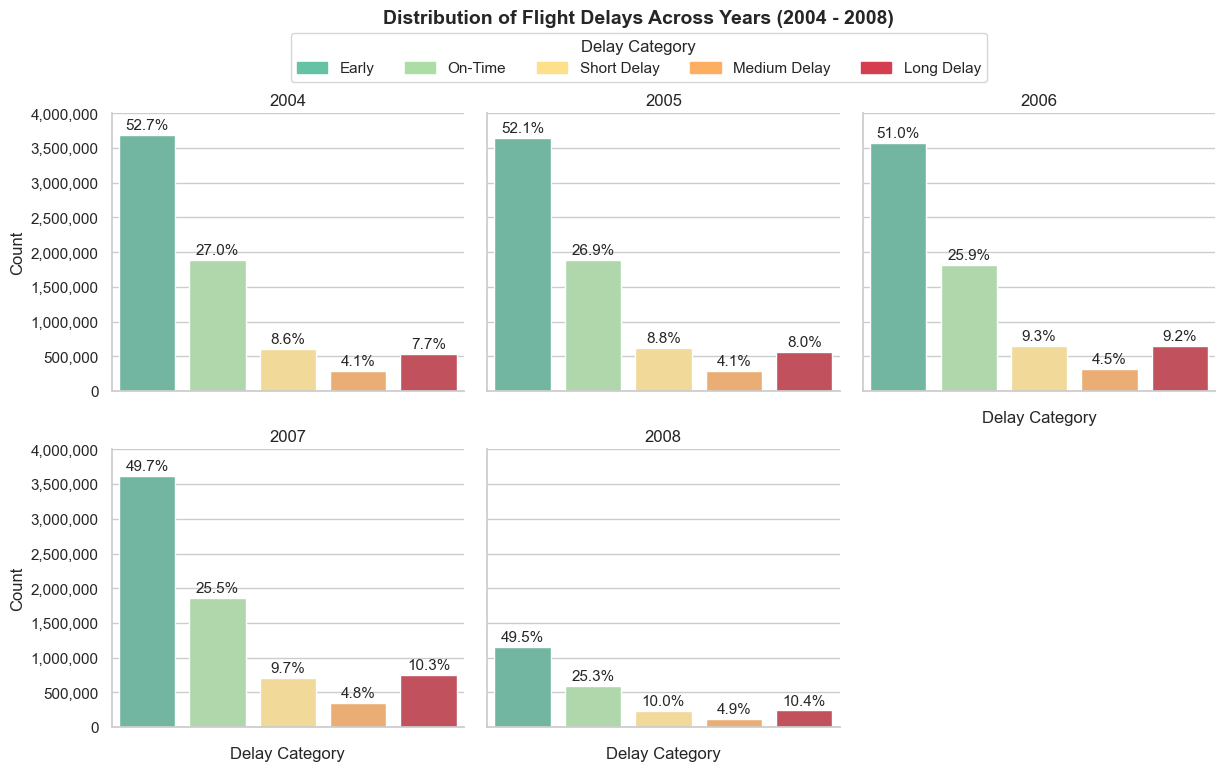

In [9]:
# Ploting faceted bar chart showing delay counts and percentages per year
plt.figure(figsize = (18, 6))
bar_palette = {
    "Early": "#66c2a5",
    "On-Time": "#abdda4",
    "Short Delay": "#fee08b",
    "Medium Delay": "#fdae61",
    "Long Delay": "#d53e4f"
}
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data = delay_perc,
    x = "delay_category", y = "count", hue = "delay_category",
    col = "Year", kind = "bar", col_wrap = 3,
    palette = bar_palette, height = 4, aspect = 1, legend = False
)
g.set_axis_labels("Delay Category", "Count")
g.set_titles("{col_name}")
g.set_xticklabels(rotation = 45, ha = 'right')

# Add percentage labels to each bar
for ax, (_, group) in zip(g.axes.flatten(), delay_perc.groupby("Year")):
    bars = ax.patches
    for i, bar in enumerate(bars):
        perc = group.iloc[i % len(group)]['percentage']
        ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_height() + 40000,
                f"{perc:.1f}%", 
                ha = 'center', va = 'bottom', fontsize = 11
            )
for ax in g.axes.flatten():
    ax.set_ylim(0, 4000000)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Addiing Colour legends into bar chart
legend_patches = [mpatches.Patch(color = color, label = label) for label, color in bar_palette.items()]
g.fig.legend(handles = legend_patches, title = "Delay Category", loc = 'upper center', bbox_to_anchor = (0.5, 0.96), ncols = 5)

# Plotting the faceted bar chart
plt.subplots_adjust(top = 0.85)
g.fig.suptitle("Distribution of Flight Delays Across Years (2004 - 2008)", fontsize = 14, weight = 'bold')
plt.show()

In [47]:
# Extract departure and arrival hours, and bin the departute hour into 3-hour groups
flights_filtered['dep_hour'] = (flights_filtered['DepTime'] // 100).astype(int)
flights_filtered['arr_hour'] = (flights_filtered['ArrTime'] // 100).astype(int)
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
labels = ["0-2", "3-5", "6-8", "9-11", "12-14", "15-17", "18-20", "21-23"]
flights_filtered['hr_grp'] = pd.cut(flights_filtered['dep_hour'], bins = bins, labels = labels, right = False, include_lowest = True)

# Convert numeric day of week to readable labels and reverse order for heatmap
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
flights_filtered['DayOfWeek'] = flights_filtered['DayOfWeek'].map(dict(zip(range(1, 8), day_labels)))
flights_filtered['DayOfWeek'] = pd.Categorical(flights_filtered['DayOfWeek'], categories = day_labels, ordered = True)
flights_filtered['hr_grp'] = pd.Categorical(flights_filtered['hr_grp'], categories = labels, ordered = True)


In [48]:
# Group by Year, DayOfWeek and hr_grp to get average arrival delays
arr_delay_heatmap = flights_filtered.groupby(['Year', 'DayOfWeek', 'hr_grp'], observed = True)['ArrDelay'].mean().reset_index(name = 'avg_arr_delay')

# Compute average delay per 3-hour block for each year
block_benchmark = flights_filtered.groupby(['Year', 'hr_grp'], observed = True)['ArrDelay'].mean().reset_index(name = 'block_average_delay')

# Compute overall block average for each year
overall_block_avg = block_benchmark.groupby('Year')['block_average_delay'].mean().reset_index()
overall_block_avg.rename(columns = {'block_average_delay': 'overall_delay'}, inplace = True)

# Add delay category for each 3-hour block based on benchmark values
block_coloured = block_benchmark.copy()
block_coloured['block_delay_category'] = pd.cut(
    block_coloured['block_average_delay'],
    bins = [-np.inf, 0, 15, 30, 45, np.inf],
    labels = ["Early", "On-Time", "Short Delay", "Medium Delay", "Long Delay"],
    right=False
)

In [23]:
# Display summary table of average delay for each hour group and year
for year in block_coloured['Year'].unique():
    year_data = block_coloured[block_coloured['Year'] == year].copy()
    year_data = year_data.sort_values(by='hr_grp')
    print(f"\nYear: {year}")
    overall = overall_block_avg[overall_block_avg['Year'] == year]['overall_delay'].values[0]
    print(f"Overall Block Avg Delay: {overall:.1f} mins")
    print(year_data[['hr_grp', 'block_average_delay', 'block_delay_category']].to_string(index = False))



Year: 2004
Overall Block Avg Delay: 12.3 mins
hr_grp  block_average_delay block_delay_category
   0-2            52.040885           Long Delay
   3-5            -5.525787                Early
   6-8            -1.307891                Early
  9-11             2.368363              On-Time
 12-14             5.026713              On-Time
 15-17             8.415991              On-Time
 18-20            13.440367              On-Time
 21-23            23.797728          Short Delay

Year: 2005
Overall Block Avg Delay: 13.7 mins
hr_grp  block_average_delay block_delay_category
   0-2            57.327124           Long Delay
   3-5            -4.818188                Early
   6-8            -1.264692                Early
  9-11             2.662029              On-Time
 12-14             5.440675              On-Time
 15-17             9.206787              On-Time
 18-20            14.399722              On-Time
 21-23            26.381858          Short Delay

Year: 2006
Overall Bloc

In [49]:
# Merge both averages and calculate the difference
arr_delay_heatmap = arr_delay_heatmap.merge(block_benchmark, on=['Year', 'hr_grp'])
arr_delay_heatmap['diff'] = arr_delay_heatmap['avg_arr_delay'] - arr_delay_heatmap['block_average_delay']

# Categorize delay class based on difference from block average
arr_delay_heatmap['delay_class'] = pd.cut(
    arr_delay_heatmap['diff'],
    bins = [-np.inf, -2, 2, np.inf],
    labels = ["Below Average", "Average", "Above Average"]
)

# Define color palette for the delay classes
delay_colours = {
    "Below Average": "#2ECC71",
    "Average": "#F4D03f",
    "Above Average": "#E74C3C"
}

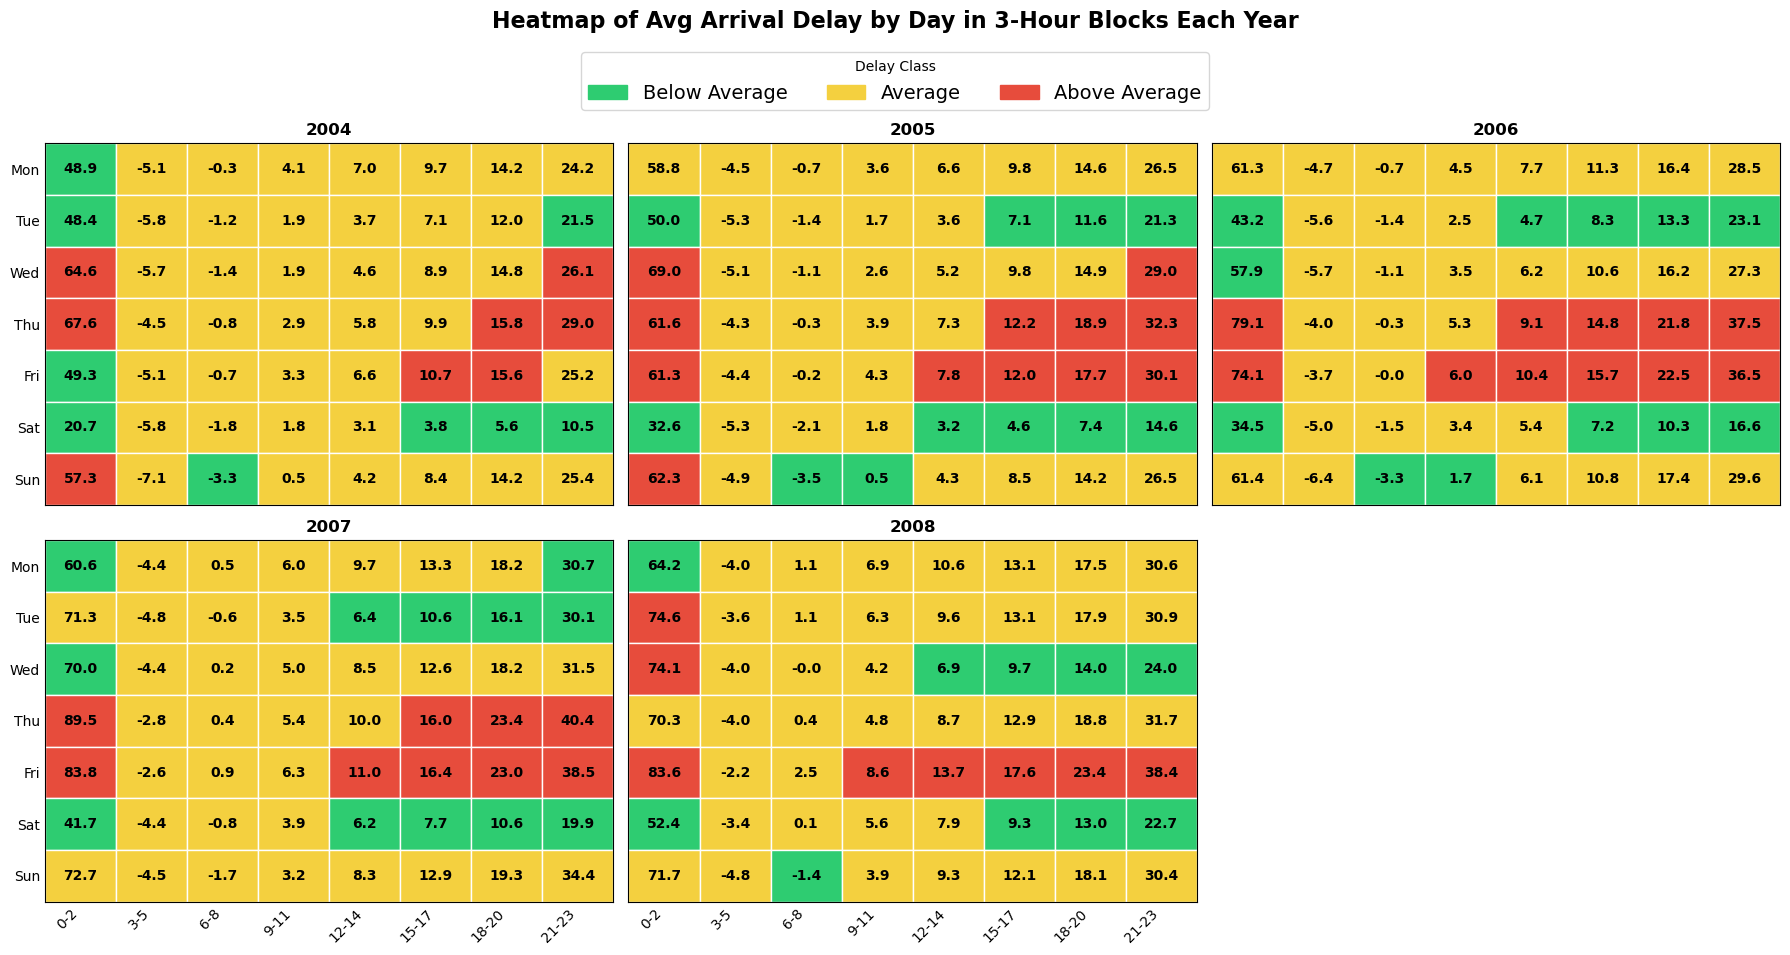

In [ ]:
# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot one heatmap per year
for i, year in enumerate(years):
    ax = axes[i]
    data = arr_delay_heatmap[arr_delay_heatmap['Year'] == year].copy()
    pivot_vals = data.pivot(index='DayOfWeek', columns='hr_grp', values='avg_arr_delay').reindex(index=days, columns=hours)
    pivot_class = data.pivot(index='DayOfWeek', columns='hr_grp', values='delay_class').reindex(index=days, columns=hours)

    for y_idx, day in enumerate(days):
        for x_idx, hr in enumerate(hours):
            val = pivot_vals.loc[day, hr]
            delay_class = pivot_class.loc[day, hr]
            if not pd.isna(val):
                color = delay_colours.get(delay_class, "#FFFFFF")
                ax.add_patch(plt.Rectangle((x_idx - 0.5, y_idx - 0.5), 1, 1, color=color, ec='white'))
                ax.text(x_idx, y_idx, f"{val:.1f}", ha = 'center', va = 'center', fontsize = 10, color = 'black', fontweight = 'bold')

    ax.set_title(f"{year}", fontsize = 12, weight = 'bold')
    ax.set_xticks(np.arange(len(hours)))
    ax.set_yticks(np.arange(len(days)))
    ax.set_xticklabels(hours, rotation = 45, ha = 'right')
    ax.set_yticklabels(days)
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_xlim(-0.5, len(hours) - 0.5)
    ax.set_ylim(len(days) - 0.5, -0.5)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add legend manually
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color = color, label = label) for label, color in delay_colours.items()]
fig.legend(handles = legend_patches, title = "Delay Class", loc = 'lower center',bbox_to_anchor = (0.5, 0.87), ncol = 3, prop = {'size': 14})

# Title and layout
fig.suptitle("Heatmap of Avg Arrival Delay by Day in 3-Hour Blocks Each Year", fontsize = 16, weight='bold')
plt.tight_layout(rect = [0, 0.03, 1, 0.92])
plt.show()

### 2b) Evaluating if older planes suffer more delays on a yr-to-yr basis

In [9]:
# Importing libraries
from datetime import datetime
from matplotlib.ticker import FuncFormatter

In [10]:
# Reading the planes-data.csv data
planes_df = pd.read_csv("plane-data.csv")

In [11]:
# Trimming empty spaces and conveerting blank strings to Na
str_cols = planes_df.select_dtypes(include='object').columns
planes_df[str_cols] = planes_df[str_cols].apply(lambda col: col.str.strip())
planes_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [12]:
# Removing rows with NaN values
planes_df.dropna(inplace=True)

In [13]:
# Removing rows with NA issue dates
planes_df.loc[planes_df['year'] == 0, 'year'] = np.nan
planes_df['year'] = pd.to_numeric(planes_df['year'], errors = 'coerce')
planes_df = planes_df[planes_df['year'].notna()]

In [14]:
# Converting issue_date to datetime format, year to numeric & renaming tailnum to TailNum
planes_df['issue_date'] = pd.to_datetime(planes_df['issue_date'], format="%m/%d/%Y", errors='coerce')
planes_df = planes_df.rename(columns = {'tailnum': 'TailNum'})

In [15]:
print(planes_df.columns.tolist())


['TailNum', 'type', 'manufacturer', 'issue_date', 'model', 'status', 'aircraft_type', 'engine_type', 'year']


In [16]:
# Combining year, month, and day of month in flights_ filtered to create a new column called 'FlightDate' with the same format as issue date
flights_filtered['flight_date'] = pd.to_datetime(
    flights_filtered[['Year', 'Month', 'DayofMonth']].astype(str).agg('-'.join, axis=1),
    format="%Y-%m-%d",
    errors = 'coerce'
)

In [17]:
# Merging flights_filtered and planes_df by TailNum and selecting only tailNUm and issue_date columns
flights_filtered = flights_filtered.merge(
    planes_df[['TailNum', 'issue_date']],
    on='TailNum',
    how='left'
)

In [18]:
# Removing rows with NaN values in the issue_date column
flights_filtered = flights_filtered[flights_filtered['issue_date'].notna()]

In [19]:
# Calculating the last_flight_date and flight_age and categorising them by the fight_age_category
flights_filtered['last_flight_date'] = flights_filtered.groupby(['TailNum', 'Year'])['flight_date'].transform('max')
flights_filtered['flight_age'] = ((flights_filtered['last_flight_date'] - flights_filtered['issue_date']).dt.days / 365.25).round(2)


In [20]:
# filtering out the flights with flight_age less than 0
flights_filtered = flights_filtered[flights_filtered['flight_age'] > 0]

In [21]:
# Categorise flight_age into New, Mid-age, and Old
def age_category(age):
    if age <= 10:
        return 'New'
    elif age < 20:
        return 'Mid-age'
    else:
        return 'Old'


In [23]:
# Arranging flight_age_category in ascending order 
flights_filtered.loc[:, 'flight_age_category'] = pd.Categorical(
    np.select(
        [
          flights_filtered['flight_age'] <= 10,
         (flights_filtered['flight_age'] > 10) & (flights_filtered['flight_age'] < 20),
         flights_filtered['flight_age'] >= 20
        ],
        ['New', 'Mid-age', 'Old'],
        default = 'Unknown'
    ),
    categories = ['New', 'Mid-age', 'Old'],
    ordered = True
)


In [24]:
# Group by Year and flight_age_category and count number of planes
flight_age_dist = flights_filtered.groupby(['Year', 'flight_age_category'], observed = False)['TailNum'].nunique(). reset_index(name = 'total_planes')
flight_age_dist = flight_age_dist.sort_values(by=['Year', 'flight_age_category'])

print(flight_age_dist)


    Year flight_age_category  total_planes
0   2004                 New          2139
1   2004             Mid-age           676
2   2004                 Old             4
3   2005                 New          2358
4   2005             Mid-age           723
5   2005                 Old            37
6   2006                 New          2607
7   2006             Mid-age           760
8   2006                 Old           103
9   2007                 New          3149
10  2007             Mid-age           889
11  2007                 Old           162
12  2008                 New          3187
13  2008             Mid-age           928
14  2008                 Old           179


In [25]:
# Changing Year column to integer type 
flights_filtered['Year'] = flights_filtered['Year'].astype(int)


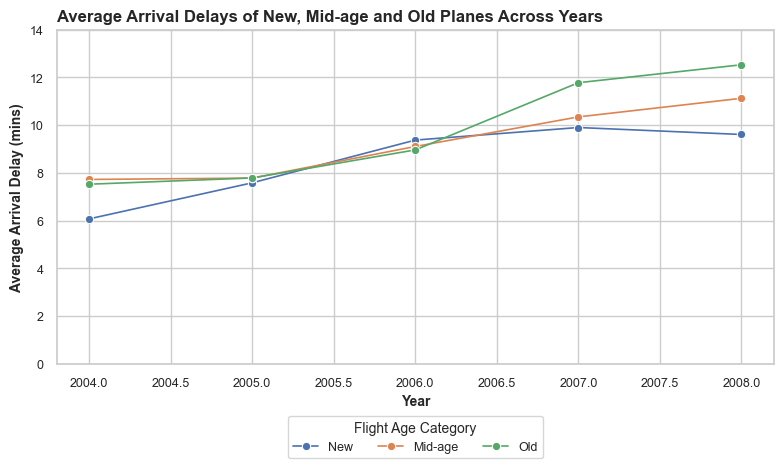

In [26]:
# Calculating average arrival delay by flight age category each year
flights_age_summary = flights_filtered.groupby(['Year', 'flight_age_category'], as_index=False, observed = False).agg(
    avg_delay=('ArrDelay', 'mean')
)

# Arranging flight_age_category again in ascending order to ensure correct arrangement after merge
flights_age_summary['flight_age_category'] = pd.Categorical(
    flights_age_summary['flight_age_category'],
    categories=['New', 'Mid-age', 'Old'],
    ordered=True
)

# Creating the line chart of average arrival delays by flight age category
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

sns.lineplot(
    data=flights_age_summary,
    x='Year',
    y='avg_delay',
    hue='flight_age_category',
    marker='o',
    linewidth = 1.2,
)

plt.title("Average Arrival Delays of New, Mid-age and Old Planes Across Years", fontsize=12, weight='bold', loc='left')
plt.xlabel("Year", fontsize=10, weight='bold')
plt.ylabel("Average Arrival Delay (mins)", fontsize=10, weight='bold')
plt.ylim(0, 14)
plt.yticks(range(0, 15, 2))
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Flight Age Category', title_fontsize=10, fontsize=9, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.show()

In [27]:
# Calculating total distance and utilisation rate
total_distance_df = flights_filtered.groupby('TailNum', as_index=False).agg(total_distance = ('Distance', 'sum'))

# Get latest age info for planes that flew in 2008. However, that means that the TailNums with no flights in 2008 will not be included.
latest_flight_age = flights_filtered[flights_filtered['Year'] == 2008]
latest_flight_age = latest_flight_age.sort_values('flight_date').drop_duplicates('TailNum', keep='last')
latest_flight_age = latest_flight_age[['TailNum', 'flight_age', 'flight_age_category']]

In [28]:
# Merge and calculate utilisation rate
util_df = total_distance_df.merge(latest_flight_age, on='TailNum', how='left')
util_df['util_rate'] = util_df['total_distance'] / util_df['flight_age']
util_df = util_df.dropna(subset=['flight_age'])


In [29]:
# Calculate average delay per TailNum
avg_delay_by_tailnum = flights_filtered.groupby('TailNum', as_index=False).agg(avg_delay=('ArrDelay', 'mean'))

# Assign quantile-based groups
util_df = util_df.merge(avg_delay_by_tailnum, on='TailNum', how='left')
util_df['util_group'] = pd.qcut(util_df['util_rate'], 3, labels=['Low', 'Medium', 'High'])

In [31]:
# Arranging flight_age_category in ascending order again to ensure correct ordering after merging
util_df['flight_age_category'] = pd.Categorical(
    util_df['flight_age_category'],
    categories=['New', 'Mid-age', 'Old'],
    ordered=True
)


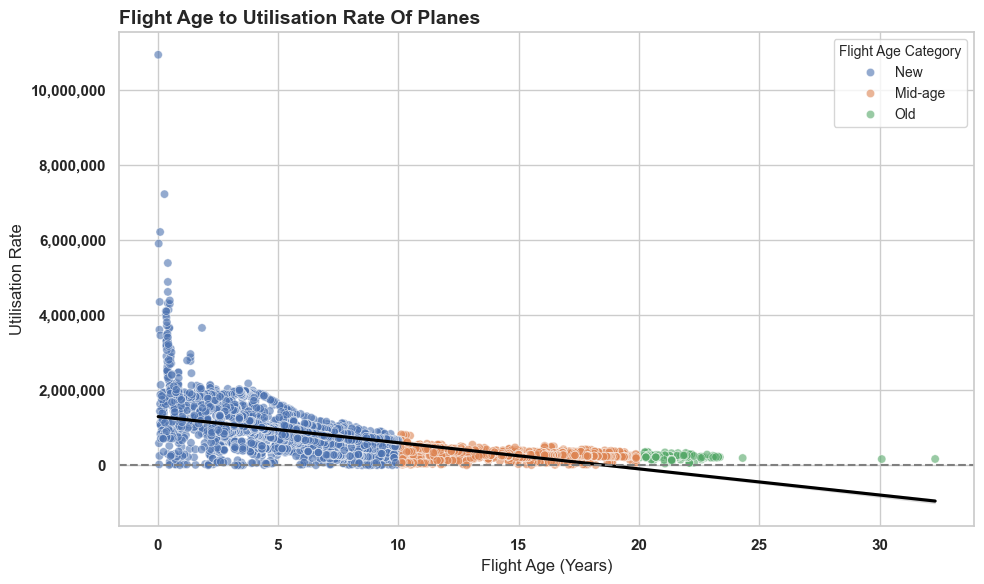

In [32]:
# Constructing a scatter plot for relationship between flight-age of planes and their utilisation rates 
plt.figure(figsize = (10, 6))
sns.set(style = "whitegrid")

scatter = sns.scatterplot(
    data = util_df,
    x = 'flight_age',
    y = 'util_rate',
    hue = 'flight_age_category',
    alpha = 0.6
)

sns.regplot(
    data = util_df,
    x = 'flight_age',
    y = 'util_rate',
    scatter = False,
    ax = scatter,
    color = 'black',
    line_kws={'linestyle': 'solid'}
)

plt.axhline(y=0, linestyle='dashed', color='gray')

# Avoid scientific notation
scatter.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.title("Flight Age to Utilisation Rate Of Planes", fontsize=14, weight='bold', loc='left')
plt.xlabel("Flight Age (Years)")
plt.ylabel("Utilisation Rate")
plt.xticks(fontsize=11, fontweight ='bold')
plt.yticks(fontsize=11, fontweight ='bold')
plt.legend(title="Flight Age Category", loc='upper right', fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.show()

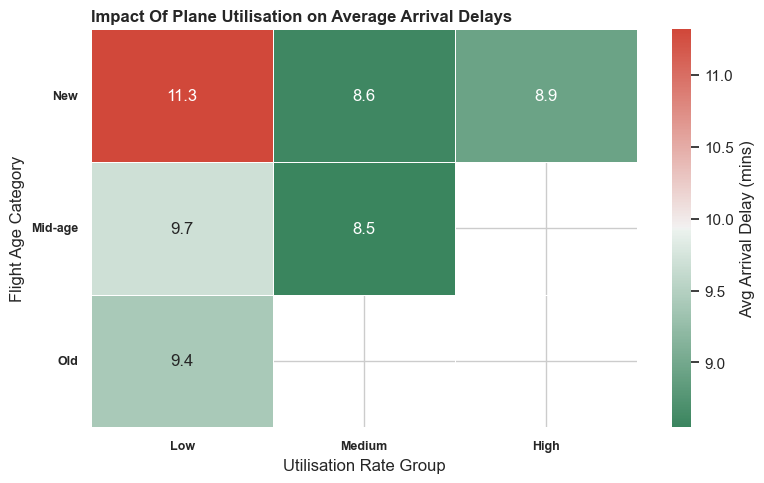

In [ ]:
# Constructing heatmap for average delay by flight age category and utilisation group
heatmap_data = utils_to_delays.pivot(index = 'flight_age_category', columns = 'util_group', values = 'group_avg_delay')

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap=sns.diverging_palette(145, 15, as_cmap=True),
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Avg Arrival Delay (mins)'}
)

plt.title("Impact Of Plane Utilisation on Average Arrival Delays", fontsize=12, weight='bold', loc='left')
plt.xlabel("Utilisation Rate Group")
plt.ylabel("Flight Age Category")
plt.xticks(fontsize=9, weight='bold')
plt.yticks(fontsize=9, weight='bold', rotation=0)
plt.tight_layout()
plt.show()


### 

### 2c) finding diverted rate and defining features that make up model 

In [25]:
# Imorting additional libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import geopandas as gpd
import plotly.express as px
import statsmodels.api as sm
from scipy.special import expit
import plotly.graph_objects as go
from statsmodels.tools import add_constant

In [4]:
# Reading the carriers and airports data
carriers_df = pd.read_csv("carriers.csv")
airports_df = pd.read_csv("airports.csv")

In [5]:
# Convert Diverted to categorical
flights_df['Diverted'] = flights_df['Diverted'].astype('category')

# Filter out cancelled flights
flights_df = flights_df[
    (flights_df['Cancelled'] == 0) &
    (flights_df['DepTime'] < 2400) &
    ((flights_df['ArrTime'] < 2400) | (flights_df['Diverted'] == 1))
].copy()

In [ ]:
# Calculating the proportion of diverted flights for each year
div_summary = flights_df.groupby('Year').agg(
    total_flights = ('Diverted', 'count'),
    div_count = ('Diverted', lambda x: (x == 1).sum())
).reset_index()
div_summary['div_percent'] = div_summary['div_count'] / div_summary['total_flights'] * 100

print(div_summary)


   Year  total_flights  div_count  div_percent
0  2004        6993592      13772     0.196923
1  2005        6996452      14024     0.200444
2  2006        7013269      16184     0.230763
3  2007        7289020      17177     0.235656
4  2008        2323620       5654     0.243327


In [ ]:
# Merging destination airport coordinates into flights_df for mapping
filtered_airports = airports_df[['iata', 'lat', 'long']]
flights_df = flights_df.merge(filtered_airports, left_on = 'Dest', right_on = 'iata', how = 'left')

In [ ]:
# Renaming columns for clarity and dropping the origin column
flights_df.rename(columns = {'lat': 'dest_lat', 'long': 'dest_long'}, inplace = True)
flights_df.drop(columns = ['Origin'], inplace = True)

In [ ]:
# Summarising diverted flights by year and destination airport for map plotting
airport_summary = flights_df.groupby(['Year', 'Dest', 'dest_lat', 'dest_long']).agg(
    total_arr = ('Diverted', 'count'),
    div_arrivals = ('Diverted', lambda x: (x == 1).sum())
).reset_index()
airport_summary['div_rate'] = airport_summary['div_arrivals'] / airport_summary['total_arr'] * 100

In [11]:
# Filtering results to top 10 airports by diversion rate per year where total arrivals are at least 50 for better analysis
top_ten_airports = airport_summary[airport_summary['total_arr'] >= 50].sort_values(['Year', 'div_rate'], ascending=[True, False]).groupby('Year').head(10)

In [12]:
# Plotting a map for the top 10 airports by diversion rate for each year 
for year in top_ten_airports['Year'].unique():
    subset = top_ten_airports[top_ten_airports['Year'] == year]
    fig = px.scatter_geo(
        subset,
        lat='dest_lat',
        lon='dest_long',
        size='total_arr',
        color='div_rate',
        text='Dest',
        title=f"Top 10 US Destination Airports by Diversion Rate ({year})",
        color_continuous_scale=["green", "yellow", "orange", "red", "darkred"]
    )
    fig.update_layout(geo_scope='usa')
    fig.show()

In [ ]:
# Converting carrier to categorical 
carriers_df['Code'] = carriers_df['Code'].astype('category')


In [9]:
# Renaming carriers column & merging engine_type data from planes_df into flights data remame
flights_df.rename(columns = {'UniqueCarrier': 'Code'}, inplace=True)
flights_df = flights_df.merge(carriers_df[['Code', 'Description']], on = 'Code', how = 'left')

In [10]:
# Renaming the Description column to carrier
flights_df.rename(columns = {'Description': 'carrier'}, inplace = True)

In [14]:
# Converting Diverted column to numeric for aggregation
flights_df['Diverted'] = pd.to_numeric(flights_df['Diverted'], errors='coerce')



In [25]:
# Calculating diversion rates by carrier and year
carrier_div = flights_df.groupby(['Year', 'carrier']).agg(
    total_flights=('Diverted', 'count'),
    div_flights=('Diverted', lambda x: (x == 1).sum())
).reset_index()
carrier_div['div_rate'] = carrier_div['div_flights'] / carrier_div['total_flights'] * 100

In [43]:
# Filtering to get the top 10 carriers by diversion rate for each year
top_div_carriers = (
    carrier_div.groupby('Year', group_keys = False)
    .apply(lambda x: x.nlargest(10, 'div_flights'))
    .reset_index(drop = True)
)

/var/folders/pl/xc9bh78x2450rhb6n_q0b7tm0000gp/T/ipykernel_22842/1672410800.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [44]:
# Cleaning long carrier names
top_div_carriers['carrier'] = top_div_carriers['carrier'].str.replace(
    r"US Airways Inc\. \(Merged with America West 9/05\. Reporting for both starting 10/07\.\)",
    "US Airways Inc.",
    regex=True
)

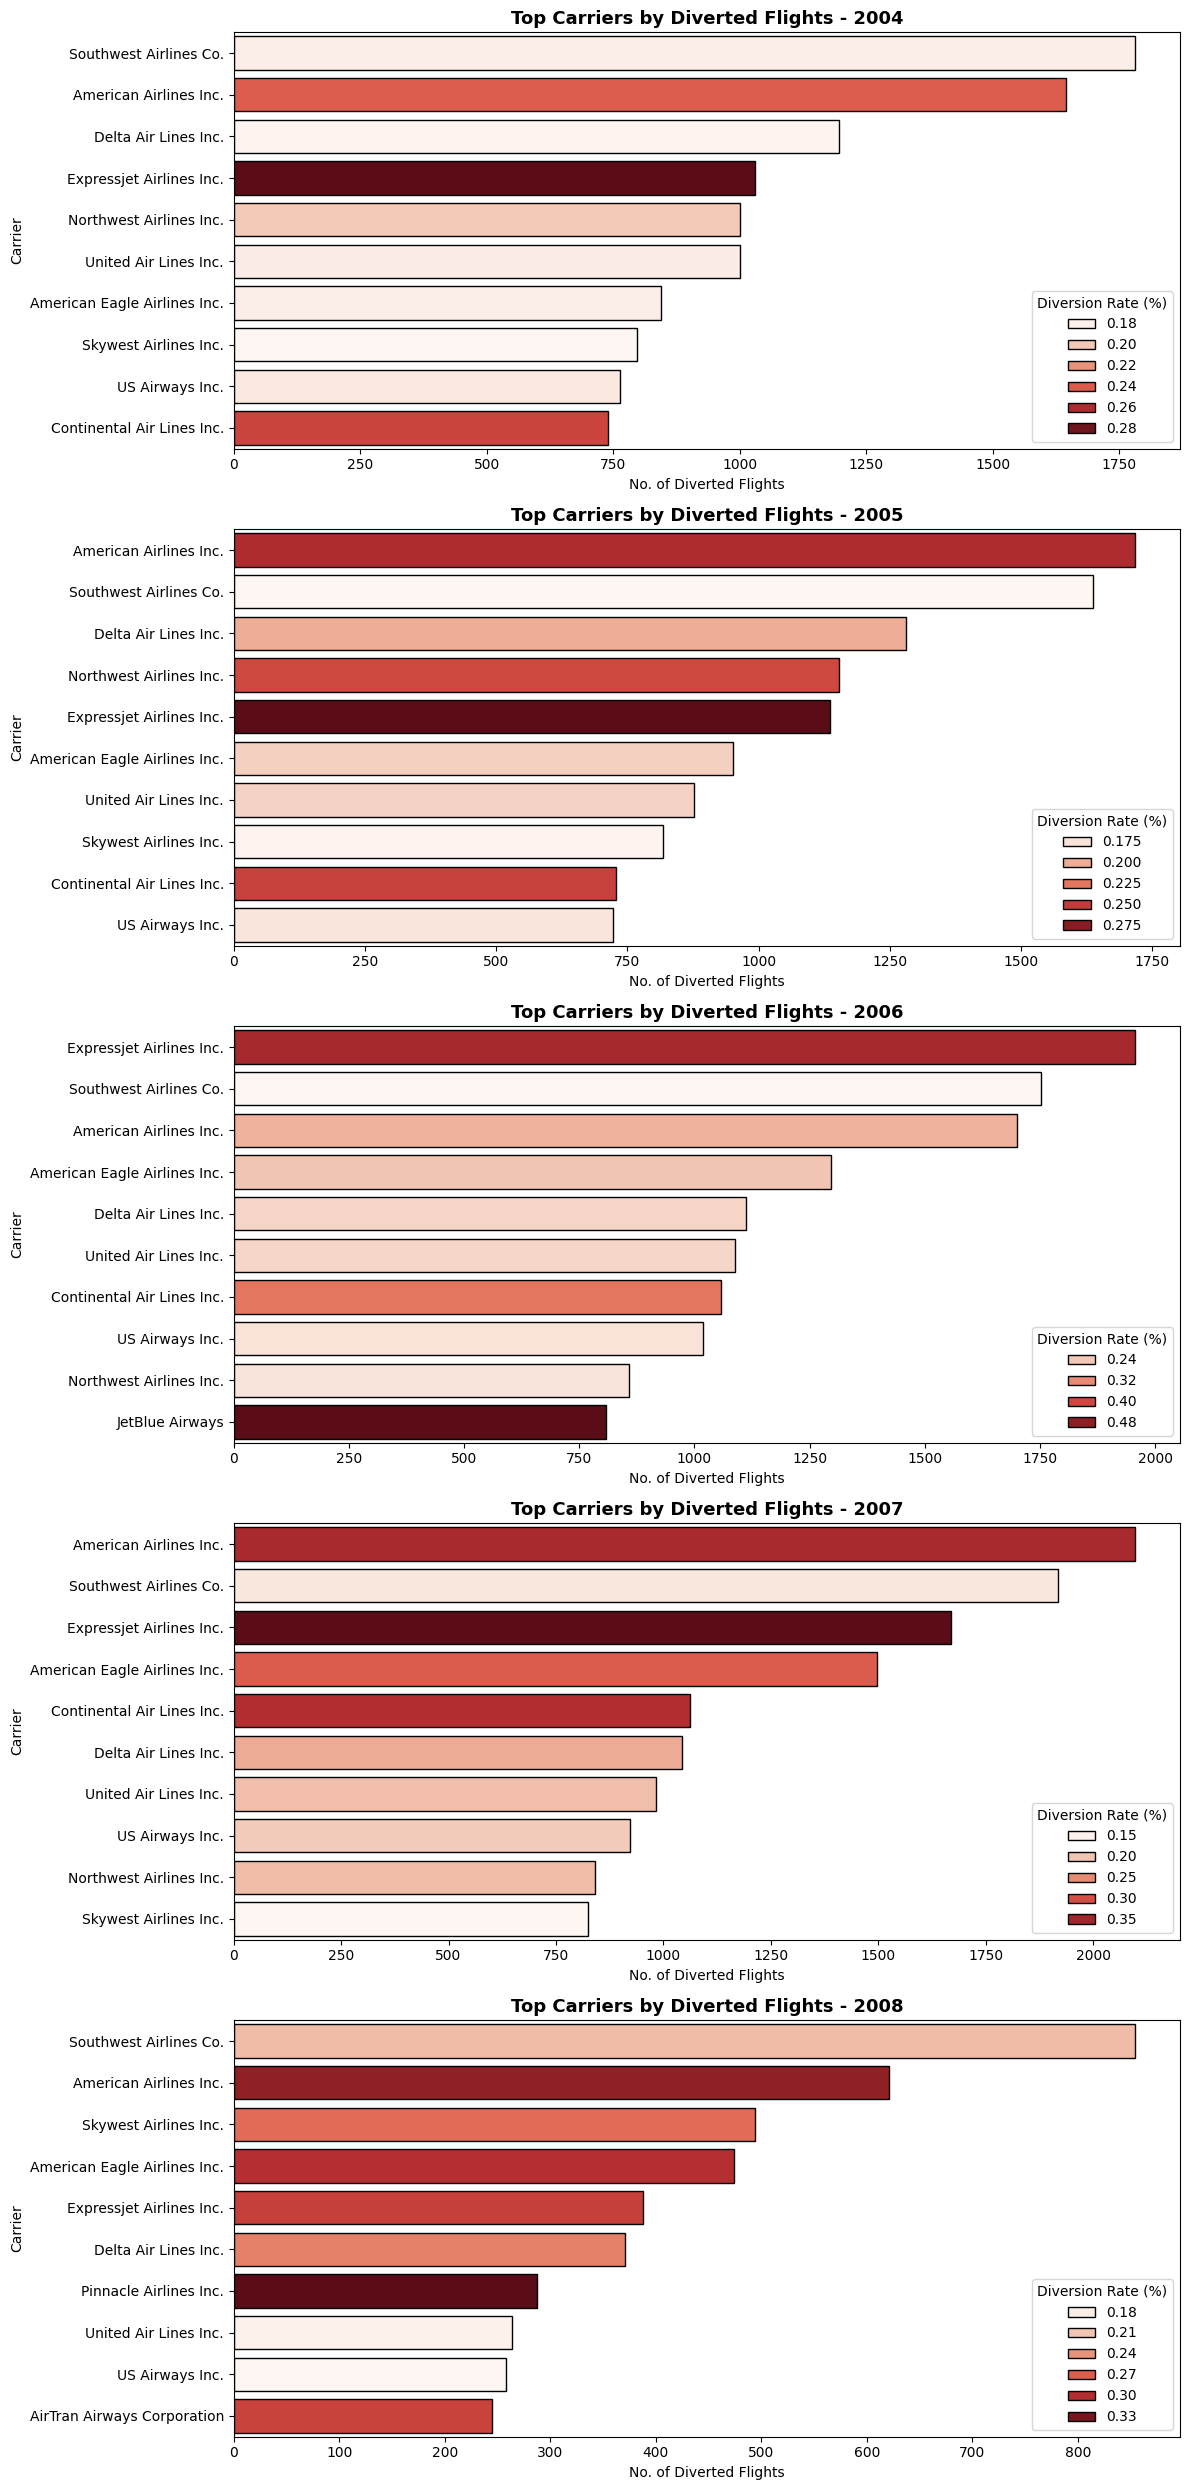

In [47]:
# Plotting the top 10 carriers by diverted flights for each year
years = sorted(top_div_carriers['Year'].unique())
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 25), sharex=False)

for ax, year in zip(axes, years):
    year_data = top_div_carriers[top_div_carriers['Year'] == year].sort_values('div_flights', ascending=False)
    sns.barplot(
        data=year_data,
        x='div_flights',
        y='carrier',
        hue='div_rate',
        dodge=False,
        palette='Reds',
        edgecolor='black',
        ax=ax
    )
    
    ax.set_title(f"Top Carriers by Diverted Flights - {year}", fontsize=13, fontweight='bold')
    ax.set_xlabel("No. of Diverted Flights")
    ax.set_ylabel("Carrier")
    ax.legend(title="Diversion Rate (%)", loc='lower right')

plt.tight_layout()
plt.show()

In [18]:
# Extracting CRS departure and arrival hours from flights_df for model
flights_df['crs_dep_hour'] = flights_df['CRSDepTime'] // 100
flights_df['crs_arr_hour'] = flights_df['CRSArrTime'] // 100
flights_df['dep_hour'] = flights_df['DepTime'] // 100
flights_df['arr_hour'] = flights_df['ArrTime'] // 100


In [19]:
# Converting carrier & engine_type into categorical for modeling
flights_df['carrier'] = flights_df['carrier'].astype('category')
flights_df['engine_type'] = flights_df['engine_type'].astype('category')

In [20]:
# Filtering out rows with empty or None engine types again for model
flights_df = flights_df[
    ~flights_df['engine_type'].isin(['', ' ', 'None']) &
    flights_df['engine_type'].notna()
]